In [1]:
!pip install cartopy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.9 MB/s eta 0:00:00


In [2]:
#Importing core libraries for data collection, processing, and visualization
import requests
import time
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as crs_module
import pandas as pd
from pyspark.sql import SparkSession


In [3]:
#Launching a PySpark session for large-scale data handling
cosmic_trajectory_spark = SparkSession.builder.appName("Orbital_Coordinates_Collector").getOrCreate()


In [4]:
#Defining function to extract current position of the ISS
def retrieve_iss_position():
    satellite_feed_url = "http://api.open-notify.org/iss-now.json"
    try:
        feed_response = requests.get(satellite_feed_url, timeout=10)
        feed_content = feed_response.json()

        current_longitude = float(feed_content["iss_position"]["longitude"])
        current_latitude = float(feed_content["iss_position"]["latitude"])
        current_utc_time = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

        print(f"ISS Location at {current_utc_time}: Longitude={current_longitude}, Latitude={current_latitude}")
        return (current_utc_time, current_longitude, current_latitude)
    except Exception as retrieval_issue:
        print("Unable to access satellite position:", retrieval_issue)
        return None


In [5]:
#Tracking ISS coordinates every 5 seconds for a full hour
collected_orbital_records = []

tracking_start = time.time()
tracking_window_seconds = 3600
tracking_end = tracking_start + tracking_window_seconds

print("Tracking initiated. Observing satellite path for 1 hour...")
while time.time() < tracking_end:
    latest_position = retrieve_iss_position()
    if latest_position:
        collected_orbital_records.append(latest_position)
    time.sleep(5)
print("Tracking session concluded.")


Tracking initiated. Observing satellite path for 1 hour...
ISS Location at 2025-04-15 16:29:53: Longitude=17.0255, Latitude=-33.7777
ISS Location at 2025-04-15 16:29:58: Longitude=17.2952, Latitude=-33.992
ISS Location at 2025-04-15 16:30:04: Longitude=17.6208, Latitude=-34.2484
ISS Location at 2025-04-15 16:30:09: Longitude=17.8938, Latitude=-34.4612
ISS Location at 2025-04-15 16:30:21: Longitude=18.5829, Latitude=-34.9901
ISS Location at 2025-04-15 16:30:26: Longitude=18.8611, Latitude=-35.2004
ISS Location at 2025-04-15 16:30:38: Longitude=19.5353, Latitude=-35.702
ISS Location at 2025-04-15 16:30:51: Longitude=20.2187, Latitude=-36.1993
ISS Location at 2025-04-15 16:30:56: Longitude=20.5062, Latitude=-36.4051
ISS Location at 2025-04-15 16:31:01: Longitude=20.7953, Latitude=-36.6102
ISS Location at 2025-04-15 16:31:06: Longitude=21.0861, Latitude=-36.8144
ISS Location at 2025-04-15 16:31:18: Longitude=21.8204, Latitude=-37.3215
Unable to access satellite position: HTTPConnectionPool

In [6]:
#Transfering collected data to a PySpark DataFrame for scalable processing
position_table_pandas = pd.DataFrame(
    collected_orbital_records, columns=["timestamp_utc", "longitude", "latitude"]
)

position_table_spark = cosmic_trajectory_spark.createDataFrame(position_table_pandas)
position_table_spark.show(5)


+-------------------+---------+--------+
|      timestamp_utc|longitude|latitude|
+-------------------+---------+--------+
|2025-04-15 16:29:53|  17.0255|-33.7777|
|2025-04-15 16:29:58|  17.2952| -33.992|
|2025-04-15 16:30:04|  17.6208|-34.2484|
|2025-04-15 16:30:09|  17.8938|-34.4612|
|2025-04-15 16:30:21|  18.5829|-34.9901|
+-------------------+---------+--------+
only showing top 5 rows



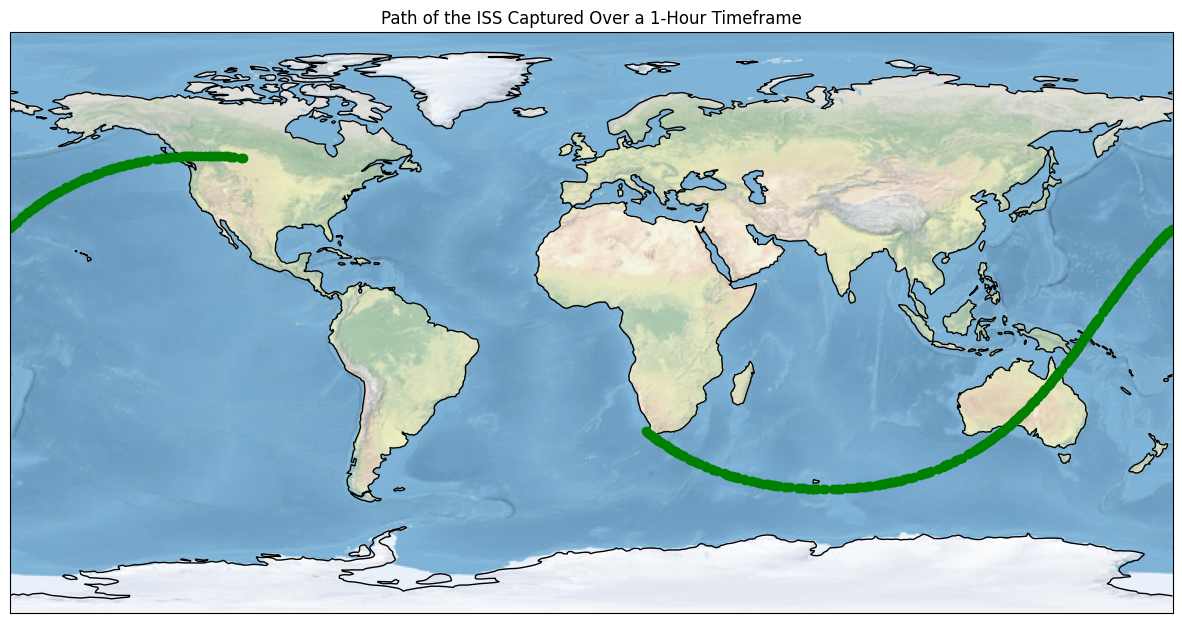

In [8]:
#Drawing the satellite trajectory on a global projection using Cartopy
def render_orbital_path_on_map(position_sequence):
    orbital_longitudes = [float(rec[1]) for rec in position_sequence]
    orbital_latitudes = [float(rec[2]) for rec in position_sequence]

    plt.figure(figsize=(15, 8))
    mapped_canvas = plt.axes(projection=crs_module.PlateCarree())
    mapped_canvas.stock_img()
    mapped_canvas.coastlines()
    mapped_canvas.plot(
        orbital_longitudes, orbital_latitudes, color='green', linewidth=2, marker='o', transform=crs_module.Geodetic()
    )
    plt.title("Path of the ISS Captured Over a 1-Hour Timeframe")
    plt.show()

render_orbital_path_on_map(collected_orbital_records)
